# 1. Author

- Student Name: Mohammad Asghar
- Student ID: 160546576

# ECS7020P Priciples of Machine Learning - Mini-Project

## Environment set up

In this section we will set up a Colab environment for the MLEnd mini-project. Before starting, follow these simple instructions:

1.   Go to https://drive.google.com/
2.   Create a folder named 'Machine Learning Mini Project' in 'MyDrive': On the left, click 'New' > 'Folder', enter the name **'MachineLearningMiniProject'**, and click 'create'
3.   Open the 'Data' folder and create a folder named **'MLEnd'**.

The mini-project consist of two separate components:

1.   **Basic component**: Using the MLEnd Yummy Dataset, build a machine learning pipeline that takes as an input a photo of a dish that has either rice or chips and predicts whether the picture has rice or chips.
2.   **Advanced component**: Formulate your own machine learning problem and build a machine learning solution using the MLEnd Yummy Dataset.

# 2. Problem Formulation

In this notebook, we will be working on the `Advanced component`. The problem is to classify images of dishes into two categories: dishes containing **'Chicken'** or dishes containing **'Potato'**. The interesting aspect of this problem lies in the visual classification of food items, which can be challenging due to variations in image quality, dish presentation, and ingredients. This task is practical and relevant in food identification applications or dietary monitoring systems.

Let's start by loading a few useful Python libraries and mounting our personal Google Drive storage system (i.e. making it available, so that Colab can access it).

In [2]:
!pip install mlend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00


In [3]:
pip install --upgrade mlend

In [4]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spkit as sp

from skimage import exposure
from skimage.color import rgb2hsv, rgb2gray
import skimage as ski

import mlend
from mlend import download_yummy_small, yummy_small_load

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

drive.mount('/content/drive')

Mounted at /content/drive


# 3. Machine Learning Pipeline

**Input: Images of dishes**

- Data Preprocessing: Loading, filtering, and organizing the dataset.
- Transformation Stage (Feature Extraction): Extracting features like color components, GLCM, and LBP from images.
- Modelling (Model Training): Utilizing a Linear Support Vector Machine (SVM) model for classification.
- Methodology (Model Evaluation): K-fold cross-validation to assess model performance.

**Output: Predictions for dish categories (Chicken or Potato)**.

## 3.1. Data Preprocessing

### 1. Download Data

In this section, we'll acquire the complete **MLEnd Yummy Dataset**, comprising a total of 3250 samples encompassing various dishes. Rather than utilizing `'download_yummy_small'`, we'll employ `'download_yummy'` for this purpose.

Run the next code cell to download the MLEnd Yummy Dataset.

In [5]:
import mlend
from mlend import download_yummy, yummy_load

subset = {}

datadir = download_yummy(save_to = '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd', subset = subset,verbose=1,overwrite=False)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|3250\3250|003250.jpg
Done!


And now we can run the following cell to check the contents of the folder where the data has been uploaded.

In [6]:
os.listdir(datadir)

['MLEndYD_images',
 'MLEndYD_image_attributes_benchmark (1).gsheet',
 'MLEndYD_image_attributes_benchmark.gsheet',
 'yummy',
 'filtered_data.csv',
 'MLEndYD_image_attributes_benchmark.csv']

As you can see, there is a subfolder (`'MLEndYD_images'`) together with a CSV file (`'MLEndYD_image_attributes_benchmark.csv'`). The subfolder contains all the photos in the MLEnd Yummy dataset. The contents of this folder can be checked via Google Drive.

### 2. Understanding our dataset

Each sample in the MLEnd Yummy Dataset corresponds to one dish instance and is described by 9 attributes, namely:

- **Photo of the dish**: Image file name or identifier corresponding to the dish photo.
- **Diet**: Dietary classification indicating whether the dish is vegetarian or non-vegetarian.
- **Cuisine**: The origin or style of cuisine associated with the dish.
- **Dish name**: The name or label of the dish.
- **Whether home or restaurant**: Indicates whether the dish is prepared at home or in a restaurant.
- **Ingredients**: List of components used in preparing the dish.
- **Healthiness rating**: A subjective evaluation of the dish's healthiness level.
- **Healthiness rating in integers**: Numerical representation of the healthiness rating.
- **Likeness rating**: Subjective assessment of how much the dish is liked or preferred.
- **Likeness rating in integers**: Numerical representation of the likeness rating.
- **Benchmark_A**: Distinguishing between Train and Test Data

We can imagine the MLEnd Yummy Dataset as a table that has 3250 rows and 11 columns. Tables are a useful abstractions, but at the end of the day, we need to store the values of the attributes of each sample somewhere. Most of the attributes are text-based, and therefore can be stored using a text file, for instance, a CSV file. However, the photo attribute is a complex one that is not suitable to be stored in a text file. Consequently, we stored each photo in the separate folder *MLEndYD_images* as a JPEG file.

The CSV file *MLEndYD_image_attributes_benchmark.csv* captures the values of all the attributes of each sample. However, instead of an actual photo, this CSV file stores the name of the photo, e.g. '00001.jpg', that is stored in the separate folder *MLEndYD_images_small*.

Let's look at the contents of this CSV file.

In [7]:
import pandas as pd
import os

# Assuming MLEndYD_image_attributes_benchmark.csv contains the data
MLENDYD_df = pd.read_csv('/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_image_attributes_benchmark.csv').set_index('filename')
MLENDYD_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A
filename,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train
000002.jpg,non_vegetarian,english,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",unhealthy,2.0,like,4.0,Train
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train
000004.jpg,vegetarian,indian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",unhealthy,2.0,strongly_like,5.0,Train
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train
...,...,...,...,...,...,...,...,...,...,...,...
003246.jpg,vegetarian,indian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",healthy,4.0,strongly_like,5.0,Train
003247.jpg,vegetarian,indian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",healthy,4.0,strongly_like,5.0,Test
003248.jpg,vegetarian,indian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",very_unhealthy,1.0,like,4.0,Test


We're filtering the dataframe to extract specific rows related to `'Chicken'` and `'Potato'`, reducing the total rows to 1046 by excluding the others. To achieve this, a new column named `'Chicken_Potato'` is created and populated with *'Chicken'*, *'Potato'*, or *'Both'* based on the data.

Additionally, we've introduced a new column in the filtered dataframe called `'Path'`, housing links directing to the image files stored in Google Drive.

In [8]:
# Adding a new column 'Chicken_Potato' with default values as None
MLENDYD_df['Chicken_Potato'] = None

# Function to check for 'chicken' or 'potato' in a text string
def check_chicken_potato(text):
    if 'chicken' in text.lower() and 'potato' in text.lower():
        return 'Both'
    elif 'potato' in text.lower():
        return 'Potato'
    elif 'chicken' in text.lower():
        return 'Chicken'
    else:
        return None

# Applying the function to 'Dish_name' and 'Ingredients' columns to fill 'Chicken_Potato'
MLENDYD_df['Chicken_Potato'] = MLENDYD_df[['Dish_name', 'Ingredients']].apply(lambda x: check_chicken_potato(' '.join(x)), axis=1)

# Filtering the DataFrame to include specific cases
filtered_df = MLENDYD_df[MLENDYD_df['Chicken_Potato'].isin(['Chicken', 'Potato'])]

# Displaying the filtered DataFrame
filtered_df

image_dir = '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/'
filtered_df['Path'] = image_dir + filtered_df.index
filtered_df

<ipython-input-8-ebb1ce079186>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Chicken_Potato,Path
filename,,,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000007.jpg,non_vegetarian,indian,indian,chicken_cheese_mushroom_wrap,home,"chicken,cheese,mayonnaise,salt,red_chilli_powd...",healthy,4.0,strongly_like,5.0,Test,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000010.jpg,vegetarian,indian,indian,spiced_mixed_vegetable_curry_with_bread_rolls,home,"potatoes,tomatoes,green_bell_peppers,onions,gr...",healthy,4.0,strongly_like,5.0,Test,Potato,/content/drive/MyDrive/MachineLearningMiniProj...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
003230.jpg,non_vegetarian,egyptian,egyptian,chicken_shawerma,home,"chicken,lemon,garlic,coriander,cumin,cardamom,...",healthy,4.0,strongly_like,5.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
003235.jpg,non_vegetarian,singapore,singaporean,singapore_style_noodles,asda,"cooked_rice_noodles,roasted_chicken,water,red_...",very_healthy,5.0,like,4.0,Test,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
003236.jpg,non_vegetarian,german/turkish,german_turkish,german_doner_kebab,gdk,"lettuce,tomato,onion,red_cabbage,bread,yoghurt...",unhealthy,2.0,strongly_like,5.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...


Note that there are 1046 rows and 13 columns. The first column is used both as a unique indentifier (index) of the sample and also as a link to the photo of the dish. Pandas do not include the index column in the column count, and that's why it reports that the table has 13 columns.

The 12th column ('Benchmark_A') is one that we have added for benchmarking purposes. This column indicates whether a sample should be used for training or for testing. Note that no sample is included in both training and test.

The dataframe contains significantly more rows for `'Chicken'` in comparison to `'Potato'`. Therefore, in this cell, we'll calculate the count for both items within the `'Chicken_Potato'` column to determine the number of rows dedicated to each item.

In [9]:
import pandas as pd

# Count rows with 'Chicken' under 'Chicken_Potato' column
chicken_count = filtered_df[filtered_df['Chicken_Potato'] == 'Chicken'].shape[0]

# Count rows with 'Potato' under 'Chicken_Potato' column
potato_count = filtered_df[filtered_df['Chicken_Potato'] == 'Potato'].shape[0]

# Count rows with 'Both' under 'Chicken_Potato' column
both_count = filtered_df[filtered_df['Chicken_Potato'] == 'Both'].shape[0]

print(f"Rows with 'Chicken' under 'Chicken_Potato' column: {chicken_count}")
print(f"Rows with 'Potato' under 'Chicken_Potato' column: {potato_count}")
print(f"Rows with 'Both' under 'Chicken_Potato' column: {both_count}")

Rows with 'Chicken' under 'Chicken_Potato' column: 683
Rows with 'Potato' under 'Chicken_Potato' column: 363
Rows with 'Both' under 'Chicken_Potato' column: 0


Given the substantial difference in row counts between `'Chicken'` and `'Potato'` with `'Chicken'` being almost twice more prevalent — we will select 363 rows for each item. These selected rows will constitute a new dataframe specifically tailored for the machine learning pipeline.

In [10]:
# Filtered DataFrame containing 'Chicken' and 'Potato'
chicken_df = filtered_df[filtered_df['Chicken_Potato'] == 'Chicken'].head(363)
potato_df = filtered_df[filtered_df['Chicken_Potato'] == 'Potato'].head(363)

# Concatenating both DataFrames
desired_df = pd.concat([chicken_df, potato_df])

# Displaying the new DataFrame
desired_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Chicken_Potato,Path
filename,,,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000007.jpg,non_vegetarian,indian,indian,chicken_cheese_mushroom_wrap,home,"chicken,cheese,mayonnaise,salt,red_chilli_powd...",healthy,4.0,strongly_like,5.0,Test,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000011.jpg,non_vegetarian,indian,indian,chicken_wings,home,"chiicken,garam_masala,turmeric,chillypowder,co...",neutral,3.0,strongly_like,5.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
003183.jpg,non_vegetarian,english,english,shepherd's_pie,home,"olive_oil,potato,white_wine,beef,garlic,butter",neutral,3.0,neutral,3.0,Train,Potato,/content/drive/MyDrive/MachineLearningMiniProj...
003193.jpg,vegetarian,indian,indian,samosa_chat,tasty_treats_restaurant,"flour,peas,potato,warm_spices,curd,garlic,onion",healthy,4.0,strongly_like,5.0,Train,Potato,/content/drive/MyDrive/MachineLearningMiniProj...
003195.jpg,vegetarian,indian,indian,spicy_stir-fry_potatoes,home,"potatoes,oil,cumin,spices,salt,dried_fenugreek...",neutral,3.0,like,4.0,Train,Potato,/content/drive/MyDrive/MachineLearningMiniProj...


### 3. Create Train and Test Datasets

For the basic component, we will consider the problem of predicting whether a dish has chicken or potato using a picture of the dish as the predictor.

To solve this section, let us create two dataframes, one for the training task and another one for the test task. We will use the `yummy_load` function included in our `mlend` library for this, and will specify which dataframe each sample should belong to, by using the column 'Benchmark_A' in the CSV file.

In [11]:
Train_df = desired_df[desired_df['Benchmark_A'] == 'Train']
Test_df = desired_df[desired_df['Benchmark_A'] == 'Test']

In [12]:
Train_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Chicken_Potato,Path
filename,,,,,,,,,,,,,
000001.jpg,non_vegetarian,japanese,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",neutral,3.0,like,4.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000003.jpg,non_vegetarian,chinese,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",neutral,3.0,strongly_like,5.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000005.jpg,non_vegetarian,indian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",healthy,4.0,strongly_like,5.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000011.jpg,non_vegetarian,indian,indian,chicken_wings,home,"chiicken,garam_masala,turmeric,chillypowder,co...",neutral,3.0,strongly_like,5.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000026.jpg,non_vegetarian,pakistani,pakistani,chicken_biryani,home,"rice,chicken,biryani_masala,yogurt,oil,green_c...",healthy,4.0,strongly_like,5.0,Train,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
003181.jpg,non_vegetarian,american,american,beef_burger_and_chips,flames,"burgen_bun,onion,cheese,ketchup,lettuce,tomato...",neutral,3.0,strongly_like,5.0,Train,Potato,/content/drive/MyDrive/MachineLearningMiniProj...
003183.jpg,non_vegetarian,english,english,shepherd's_pie,home,"olive_oil,potato,white_wine,beef,garlic,butter",neutral,3.0,neutral,3.0,Train,Potato,/content/drive/MyDrive/MachineLearningMiniProj...
003193.jpg,vegetarian,indian,indian,samosa_chat,tasty_treats_restaurant,"flour,peas,potato,warm_spices,curd,garlic,onion",healthy,4.0,strongly_like,5.0,Train,Potato,/content/drive/MyDrive/MachineLearningMiniProj...


In [13]:
Test_df

,Diet,Cuisine_org,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating,Healthiness_rating_int,Likeness,Likeness_int,Benchmark_A,Chicken_Potato,Path
filename,,,,,,,,,,,,,
000007.jpg,non_vegetarian,indian,indian,chicken_cheese_mushroom_wrap,home,"chicken,cheese,mayonnaise,salt,red_chilli_powd...",healthy,4.0,strongly_like,5.0,Test,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000018.jpg,non_vegetarian,south_indian,south_indian,pepper_chicken_roast,home,"chicken,crushed_pepper_powder,onion,ginger_&_g...",healthy,4.0,strongly_like,5.0,Test,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000037.jpg,non_vegetarian,american,american,chicken_sausage_and_nugget,tesco,"minced_chicken,spices,bread_crumbs,oil",unhealthy,2.0,like,4.0,Test,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000038.jpg,non_vegetarian,indian,indian,rice_with_chicken_curry,home,"boiled_rice,chicken,sunflower_oil,chilli_powde...",healthy,4.0,strongly_like,5.0,Test,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
000042.jpg,non_vegetarian,thai,thai,chicken_pad_thai,rosa's,"rice_noodles,chicken,tamarind_sauce,eggs,crush...",neutral,3.0,neutral,3.0,Test,Chicken,/content/drive/MyDrive/MachineLearningMiniProj...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
003090.jpg,vegetarian,mediterranean,mediterranean,protein_salad,home,"beans,egg,black_rice,lentils,spelt,quinoa,barl...",very_healthy,5.0,strongly_like,5.0,Test,Potato,/content/drive/MyDrive/MachineLearningMiniProj...
003105.jpg,vegetarian,indian,indian,papri_chaat,home,"potatoes,onions,curd,cumin_powder,red_chilli_p...",unhealthy,2.0,like,4.0,Test,Potato,/content/drive/MyDrive/MachineLearningMiniProj...
003119.jpg,non_vegetarian,chinese,chinese,braised_pork_with_potato_in_brown_sauce,home,"streaky_pork,potato,say_sauce,salt,sugar,oil",neutral,3.0,like,4.0,Test,Potato,/content/drive/MyDrive/MachineLearningMiniProj...


The `'Train'` dataframe comprises **482 rows**, while the `'Test'` dataframe contains **244 rows**, indicating the discrepancy in their sizes.

To generate datasets for both `'Train'` and `'Test'` data, a function is created to construct a dictionary. This dictionary includes entries for the Path (**X_paths**), `'Chicken_Potato'` column encompassing both *'Chicken'* and *'Potato'* dishes represented through **'Y'**, and the encoding of **'Y'** (Y_encoded). The encoding designates 'Chicken' as 1 and 'Potato' as 0.

In [14]:
import numpy as np

def dataset_dictionary(df):
    dataset_dict = {
        'X_paths': df['Path'].tolist(),
        'Y': np.array(df['Chicken_Potato'].tolist(), dtype=object),
        'Y_encoded': np.array(df['Chicken_Potato'].apply(lambda x: 1 if x == 'Chicken' else 0).tolist(), dtype=object)
    }
    return dataset_dict

Once we have defined the function, we can use it get the results dictionary using our dataframe which would include the results for all the variables **'X_paths'**, **'Y'**, & **'Y_encoded'**.

In [15]:
result_dict = dataset_dictionary(desired_df)
result_dict

{'X_paths': ['/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000001.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000003.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000005.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000007.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000011.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000018.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000026.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000037.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000038.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/yummy/MLEndYD_images/000042.jpg',
  '/content/drive/MyDrive/MachineLearningMiniProject/MLEnd/

Subsequently, we'll generate the **'Train'** and **'Test'** datasets by involing the `'dataset_dictionary'` function. This function will utilize 'Train_df' as input for `'TrainSet'` and 'Test_df' for `'TestSet'`.

In [16]:
TrainSet = dataset_dictionary(Train_df)
TestSet = dataset_dictionary(Test_df)

In [17]:
TrainSet.keys()

dict_keys(['X_paths', 'Y', 'Y_encoded'])

In [18]:
TestSet.keys()

dict_keys(['X_paths', 'Y', 'Y_encoded'])

Lets plot all the labels in the training dataset using the values **'Chicken'** and **'Potato'**.

In [19]:
TrainSet['Y']

array(['Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken', 'Chicken',
       'Chicken', 'Chicken', 'Chicken', 'Chicken', 

And now, let's plot the labels encoded using the values 0 (**'Potato'**) and 1 (**'Chicken'**).

In [20]:
TrainSet['Y_encoded']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Finally, let's save the predictors and labels of the training and test dataset.

In [21]:
X_train_paths = TrainSet['X_paths']
X_test_paths  = TestSet['X_paths']

Y_train = TrainSet['Y_encoded']
Y_test  = TestSet['Y_encoded']

### 4. Visualising dishes

In this section, we will visualise the images that we have extracted from the `'MLEnd Yummy Dataset'`. Specifically, we will select five dishes that contain **'Chicken'** and five dishes that have **'Potato'**.

Chicken


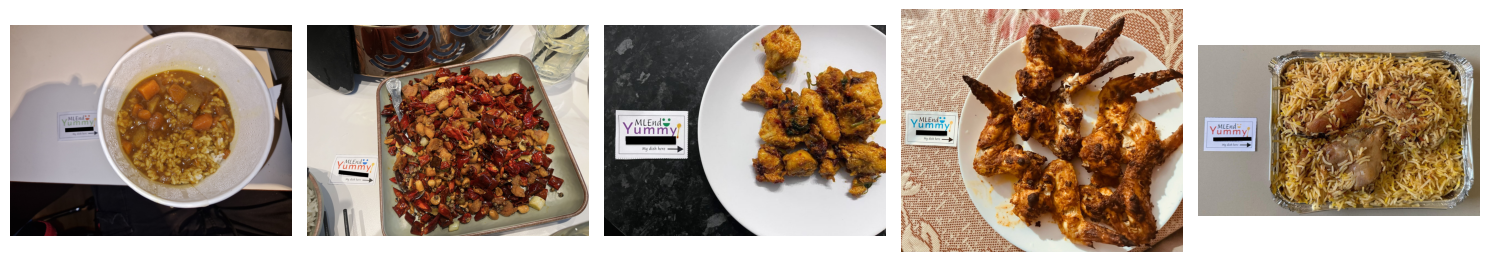

Potato


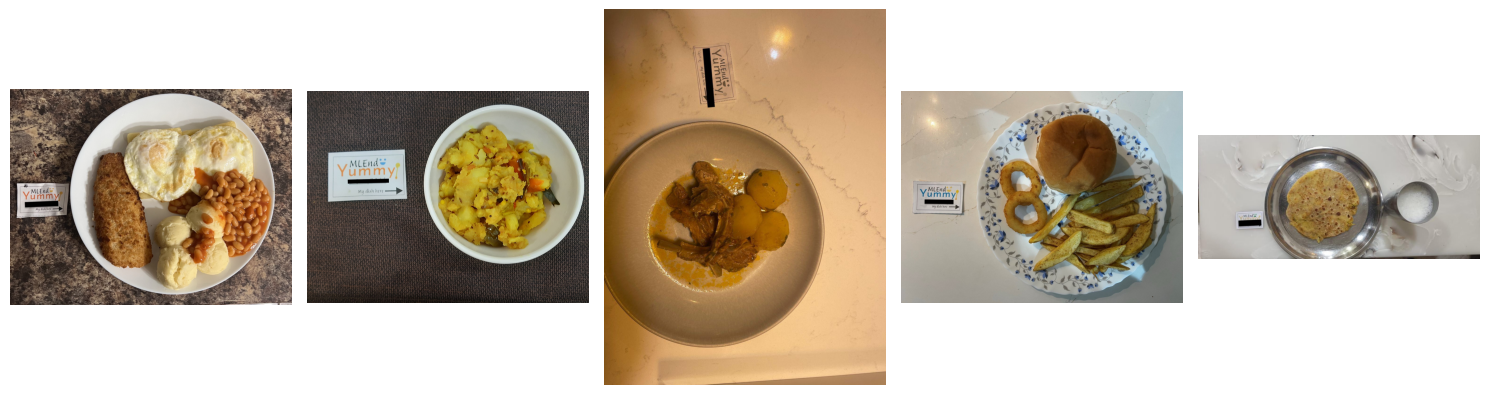

In [22]:
Potato_Img = np.array(X_train_paths)[Y_train==0]
Chicken_Img = np.array(X_train_paths)[Y_train==1]

print('Chicken')
plt.figure(figsize=(15,5))
for k,file in enumerate(Chicken_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

print('Potato')
plt.figure(figsize=(15,5))
for k,file in enumerate(Potato_Img[:5]):
  I = plt.imread(file)
  plt.subplot(1,5,k+1)
  plt.imshow(I)
  plt.axis('off')

plt.tight_layout()
plt.show()

### 5. Resizing Images

As mentioned earlier, the images vary in size. Our initial action involves resizing all images to ensure uniform dimensions. To maintain the original aspect ratio, we'll add black color to square the images. Subsequently, we'll resize them to 200 x 200 pixels.

In [23]:
def make_it_square(I, pad=0):
  N,M,C = I.shape
  if N>M:
    Is = [np.pad(I[:,:,i], [(0,0),(0, N-M)], 'constant', constant_values=pad) for i in range(C)]
  else:
    Is = [np.pad(I[:,:,i], [(0, M-N),(0,0)], 'constant', constant_values=pad) for i in range(C)]

  return np.array(Is).transpose([1,2,0])

def resize_img(I,size=[100,100]):
  N,M,C = I.shape
  Ir = [sp.core.processing.resize(I[:,:,i],size) for i in range(C)]
  return np.array(Ir).transpose([1,2,0])

In [24]:
X_train = []
for k,file in enumerate(X_train_paths):
  sp.utils.ProgBar_JL(k,len(X_train_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_train.append(I)


X_test = []
for k,file in enumerate(X_test_paths):
  sp.utils.ProgBar_JL(k,len(X_test_paths),L=50,color='blue')
  I = plt.imread(file)
  I = make_it_square(I, pad=0)
  I = resize_img(I,size=[200,200])
  X_test.append(I)

X_train = np.array(X_train)
X_test = np.array(X_test)
X_train.shape, X_test.shape

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|482\482|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|244\244|
Done!


((482, 200, 200, 3), (244, 200, 200, 3))

Now, let's plot a few images after resizing.

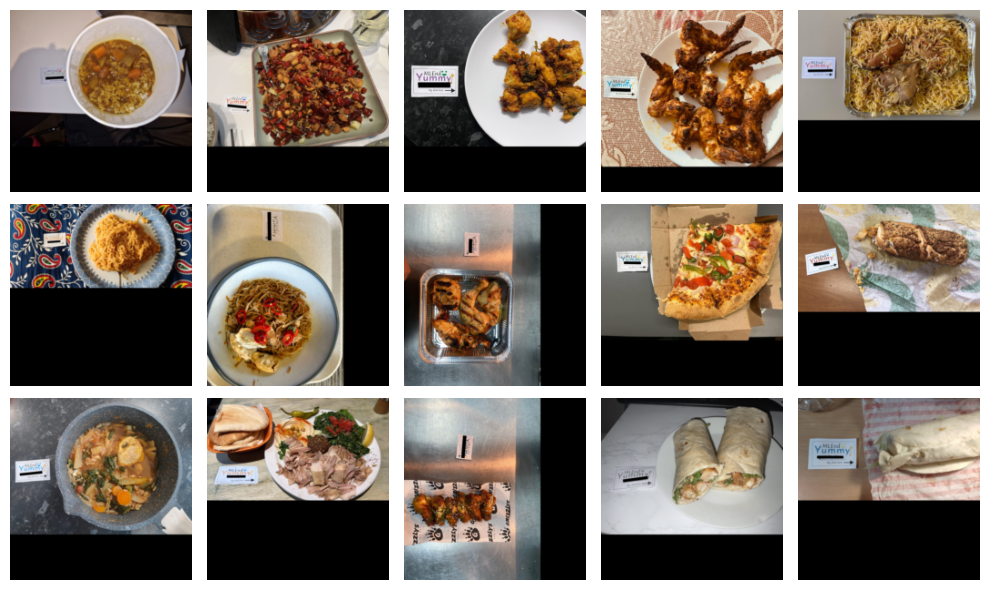

In [25]:
plt.figure(figsize=(10,6))
for k,I in enumerate(X_train):
  plt.subplot(3,5,k+1)
  plt.imshow(I)
  plt.axis('off')
  k+=1
  if k>=15:break
plt.tight_layout()
plt.show()

As you can see, all the images exhibit a square shape now, each comprising dimensions of 200 x 200 pixels.

## 3.2. Transformation Stage

- Transformation Stage: Feature Extraction
- Input: Images of dishes
- Output: Extracted features (yellow component, GLCM features, & LBP features)

Justification: The choice to extract the `yellow component` aims to identify yellow hues, aiding in recognizing ingredients like turmeric in 'Chicken' or 'Potato' dishes, pivotal for ingredient-based identification. Simultaneously, `GLCM features` play a crucial role in capturing subtle textural variations within the images, essential for discerning nuanced differences between the textures of 'Chicken' and 'Potato' dishes. Additionally, leveraging `LBP features` enables the recognition of distinct local texture patterns, allowing the model to differentiate between surface characteristics unique to each dish type, further enhancing their classification accuracy.

### 1. Feature Extraction

Addressing the challenge of predicting whether a dish contains **'Chicken'** or **'Potato'** using 200 x 200 pixel photos as predictors necessitates addressing the dimensionality of the data. Each photo is represented by 3 x 200 x 200 = 120,000 values, resulting in a predictor space with 120,000 dimensions. For effective model training, we ideally require a training dataset comprising more than 120,000 samples. However, our current training dataset is notably smaller.

To tackle this issue, we need to reduce the dimensionality of the predictor space. In simpler terms, we aim to shift our samples from a 120,000-dimensional space to a lower-dimensional space. Feature extraction serves as a common approach to achieve this reduction in the prediction space. In the code cell below, we introduce two functions, `get_yellow_component`, `GMLC_features` and `LBP_features`, designed to extract 13 image features that will define a new, lower-dimensional predictor space.

In [41]:
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.color import rgb2gray
from skimage import measure
import numpy as np

# Function to extract yellow component
def get_yellow_component(I, t1=27, t2=33):
    Ihsv = (rgb2gray(I) * 255).astype('uint8')
    mask = (Ihsv < t2) * (Ihsv > t1)
    Ypx = mask.sum()
    return Ypx

# Function to extract GMLC features
def GMLC_features(I):
    Ig = (rgb2gray(I) * 255).astype('uint8')
    glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
    f2 = graycoprops(glcm, 'correlation')[0, 0]
    return f1, f2

# Function to extract LBP features
def LBP_features(I, P=8, R=1):
    Ig = (rgb2gray(I) * 255).astype('uint8')
    lbp = local_binary_pattern(Ig, P, R, method='uniform')
    unique, counts = np.unique(lbp, return_counts=True)
    hist = counts / np.sum(counts)
    return hist

def showConfMat(CM, labels = ['Chicken','Potato']):
  plt.matshow(CM,cmap='Blues')
  for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
      plt.text(i,j,CM[i,j].round(2),ha='center',)
  plt.xticks([0,1],labels)
  plt.yticks([0,1],labels)
  plt.show()

Now, we'll proceed to extract the 13 features from each image and generate the transformation sets named `X_train_f` and `X_test_f`.

In [42]:
# Modify feature extraction for training data to include yellow component, GMLC, and LBP features
X_train_f = []
for k, I in enumerate(X_train):
    f1 = get_yellow_component(I)
    f2, f3 = GMLC_features(I)
    f4 = LBP_features(I)  # Extracting LBP features
    X_train_f.append([f1, f2, f3] + f4.tolist())

# Modify feature extraction for test data to include yellow component, GMLC, and LBP features
X_test_f = []
for k, I in enumerate(X_test):
    f1 = get_yellow_component(I)
    f2, f3 = GMLC_features(I)
    f4 = LBP_features(I)  # Extracting LBP features
    X_test_f.append([f1, f2, f3] + f4.tolist())

Upon formatting both `X_train_f` and `X_test_f` as numpy arrays, we can examine their respective shapes.

In [43]:
X_train_f = np.array(X_train_f)
X_test_f = np.array(X_test_f)
X_train_f.shape, X_test_f.shape

((482, 13), (244, 13))

Note that `X_train_f` encompasses a dataset of 482 samples characterized by 13 attributes, while `X_test_f` consists of a set of 244 samples with 13 attributes. This stage of feature extraction has significantly reduced the dimensionality of our problem from 120,000D to 13D.

### 2. Normalisation

In addition to reducing the dimensionality of the prediction space, let's implement a normalisation stage to ensure that the 13 attributes in the new prediction space take on a similar range of values. We will implement standardisation.

In [44]:
MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)

epsilon = 1e-8
SD_adjusted = np.where(SD != 0, SD, epsilon)

X_train_fn = (X_train_f - MEAN) / SD_adjusted
X_test_fn = (X_test_f - MEAN) / SD_adjusted

## 3.3. Modelling

### 1. Linear Model

The utilization of scikit-learn's `LinearSVC` for a binary classification task—distinguishing images as **'Chicken'** or **'Potato'** via normalized attributes—is grounded in its efficacy in handling such tasks with assumed linearly separable features. This choice aligns with the model's proficiency in creating optimal linear boundaries for classification. Employing label encoding and attribute normalization, the provided code preprocesses the data to ensure model compatibility and uniform contribution of features. Subsequent implementation involves initializing the LinearSVC model with a regularization parameter, C=1, followed by `k-fold cross-validation` to assess the model's performance through mean training and testing accuracies across folds, enabling a comprehensive evaluation of its ability to discern between **'Chicken'** and **'Potato'** images.

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
import numpy as np


label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)  # Use transform for test labels

MEAN = X_train_f.mean(0)
SD = X_train_f.std(0)

epsilon = 1e-8
SD_adjusted = np.where(SD != 0, SD, epsilon)

X_train_fn = (X_train_f - MEAN) / SD_adjusted
X_test_fn = (X_test_f - MEAN) / SD_adjusted

model = LinearSVC(C=1)

## 3.4. Methodology

Models are trained using `k-fold cross-validation`, assessing performance via **accuracy scores** and **confusion matrix**. Training and testing accuracies are calculated across 7 folds to evaluate the model's generalization ability.

In [48]:
cv_scores = cross_val_score(model, X_train_fn, Y_train_encoded, cv=7)  # Set the number of folds (cv)


model.fit(X_train_fn, Y_train_encoded)


ytp = model.predict(X_train_fn)
ysp = model.predict(X_test_fn)

train_accuracy = np.mean(ytp == Y_train_encoded)
test_accuracy = np.mean(ysp == Y_test_encoded)

print('Cross-Validation Accuracy:', np.mean(cv_scores))
print('Training Accuracy:', train_accuracy)
print('Testing Accuracy:', test_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: L

Cross-Validation Accuracy: 0.5724028741931555
Training Accuracy: 0.6078838174273858
Testing Accuracy: 0.569672131147541


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.


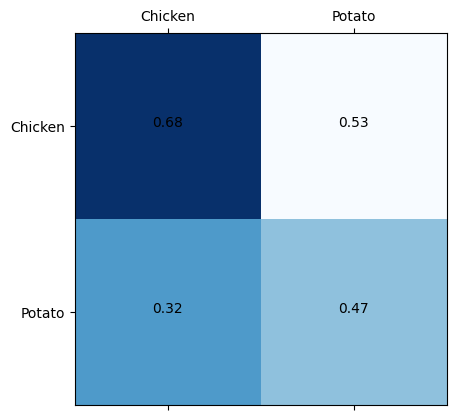

In [49]:
Ac = np.mean(ysp[Y_test.astype(int)==0]==0)
Ar = np.mean(ysp[Y_test.astype(int)==1]==1)

Mc = np.mean(ysp[Y_test.astype(int)==0]==1)
Mr = np.mean(ysp[Y_test.astype(int)==1]==0)

CM = np.array([[Ac, Mc],[Mr, Ar]])

showConfMat(CM)

# 4. Dataset

The MLEnd Yummy dataset is used, containing images of dishes with annotations. Preprocessing involves filtering the data, creating a subset with `'Chicken'` and `'Potato'` categories, and visualizing sample images from each category.

# 5. Results

1. **Accuracies**: The reported training accuracy using `LinearSVC with k-fold cross-validation` indicates the model's performance on the data it was trained on, correctly predicting whether an image contains **'Chicken'** or **'Potato'** about **60.79%** of the time. The testing accuracy represents how well the model generalizes to new, unseen data, where it correctly predicts the categories about **56.96%** of the time. The drop in accuracy from training to testing suggests potential overfitting, indicating that the model might have learned specific patterns from the training data that don't generalize well to new data. To improve performance, exploring techniques like feature engineering, trying different models or hyperparameters, collecting more diverse data, or applying regularization could be beneficial, while considering precision, recall, or other metrics might offer deeper insights into the model's strengths and weaknesses when distinguishing between Chicken and Potato images.

2. **Confusion Matrix**: The confusion matrix showcases the performance of a Linear Support Vector Classifier (`LinearSVC`) in distinguishing between **'Chicken'** or **'Potato'** dish images. It indicates that the model correctly predicted 0.68 (68%) of Chicken images as **'Chicken'**, while misclassifying 0.32 (32%) of Chicken images as **'Potato'**. Conversely, it misclassified 0.53 (53%) of Potato images as **'Chicken'** and accurately identified 0.47 (47%) of Potato images as **'Potato'**. This suggests that the model has a higher accuracy in recognizing Chicken dishes compared to Potato dishes, with a notable challenge in differentiating Potato images from Chicken ones, as more Potato images were mistaken for **'Chicken'**. Enhancing feature distinctiveness, exploring different models or hyperparameters, and potentially augmenting or balancing the dataset could be strategies to improve the model's performance in accurately classifying these dish images.

# 6. Conclusions

In pursuit of creating a machine learning pipeline for predicting **'Chicken'** or **'Potato'** dishes within images, employing a Linear Support Vector Classifier (`LinearSVC`) revealed a `training accuracy` of approximately **'60.58%'** and a `testing accuracy` of around **'56.97%'**. The observed drop in accuracy from training to testing indicates potential overfitting, emphasizing the need to enhance generalizability. Analysis via the confusion matrix highlighted the model's higher accuracy in identifying Chicken dishes (**68%**) compared to Potato dishes (**47%**), yet a significant challenge emerged in differentiating Potato images from Chicken ones, with **53%** of Potato images misclassified as 'Chicken.' To improve performance, strategies such as feature engineering for increased distinctiveness, exploration of alternate models or hyperparameters, dataset augmentation for diversity and balance, regularization techniques to curb overfitting, and the consideration of additional evaluation metrics like precision and recall could refine the model's ability to accurately classify these dish images.